Credit fraud detection is a binary classification problem and most of the time the dataset used to trained the model are highly imbalanced (0.17% of fraudulent data). This means that using a model that returns always 0 will have an accuray of 99% but his generatlisation will be poor and the classification of fraud data will be always 0%. That's why we will use accuracy and confusion matrix to evaluate the model espacialy for the minority class. In this notebook, we review different classical machine learning model that will be used as benchmark against the quantum ML model. Furthermore we handle the imbalanced using under sampled method and SMOTE method and compared both.

The classical model used are : 
- logistic regression
- XgBoost
- SVC
- MLP
- auto Encoder

In order to compare the differents approach, we use the accuracy and the confusion matrix. The accuracy allows to evaluate the overall performance of the model and the confusion matrix allows us to evaluate how the model classify the minority class.

Here are the results : 


In [183]:
import numpy as np
import pandas as pd
from pandas import *
import matplotlib.pyplot as plt
import xgboost as xgb # model
import time
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt


#Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

#Auto Encoder with Keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

#Manual Parameter
SPLIT_RATIO = 0.3
THRESHOLD_FIXED = 3

# Import the dataset

In [3]:
#data = pd.read_csv("creditcard.csv")
data = pd.read_csv("creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
print("count NA value : "+str(data.isna().sum().sum()))
print("nb of features : "+str(data.shape[1]))
print("nb of samples : "+str(data.shape[0]))

count NA value : 0
nb of features : 31
nb of samples : 284807


In [6]:
#Normalization of Amount and Time
# We do not change the other columns since they come from an internal normalization
data_norm = data.copy()
# Reshape your data either using array.reshape(-1, 1) if your data has a single feature
# or array.reshape(1, -1) if it contains a single sample.
data_norm['Time'] = StandardScaler().fit_transform(data_norm['Time'].values.reshape(-1, 1))
data_norm['Amount'] = StandardScaler().fit_transform(data_norm['Amount'].values.reshape(-1, 1))


In [7]:
data_norm.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,-3.065637e-16,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,2.913952e-17,0.001727
std,1.000002e+00,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,1.000002e+00,0.041527
min,-1.996583e+00,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,-3.532294e-01,0.000000
25%,-8.552120e-01,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,-3.308401e-01,0.000000
50%,-2.131453e-01,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,-2.652715e-01,0.000000
75%,9.372174e-01,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,-4.471707e-02,0.000000
max,1.642058e+00,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.023622e+02,1.000000


In [8]:
X = data_norm.iloc [:, data_norm.columns != 'Class']
y = data_norm.iloc [:, data_norm.columns == 'Class']

In [9]:
print("nb of fraud data : "+str(len(data_norm["Class"][data_norm["Class"]==0])))
print("nb of fraud data : "+str(len(data_norm["Class"][data_norm["Class"]==1])))
print("% of fraud data : "+str(len(data_norm["Class"][data_norm["Class"]==1])/data_norm.shape[0] * 100))
print("X data shape : "+str(X.shape))
print("y data shape : "+str(y.shape))

nb of fraud data : 284315
nb of fraud data : 492
% of fraud data : 0.1727485630620034
X data shape : (284807, 30)
y data shape : (284807, 1)


### Remark
The data set is highly unbalanced, we use 2 methods to balanced it : under sample and SMOTE

# Balanced data set

There exists differents methods to balanced dataset, we will have a look of the 3 most importants : 
- undersampling
- oversampling
- SMOTE

## under sample method

The methods consists to reduce the size of the majority class, thus the frequency of minority classes increase. This approach is interesting for Quantum model since it allows us to train the model on a reduced data set and avoid the issue of training QML on large data set which currently an issue with current simulator (time to train can be really long : month of training)

In [10]:
fraud_indices = np.array (data_norm[data_norm.Class==1].index)
normal_indices = np.array (data_norm[data_norm.Class==0].index)
number_records_fraud = len(fraud_indices)

# we reduce the size of the majority class
random_normal_indices = np.random.choice (normal_indices, number_records_fraud, replace = False )
# we combine both
under_sample_indices = np.concatenate ([fraud_indices, random_normal_indices])
# we generate the undersample dataset
under_sample_data = data_norm.iloc[under_sample_indices,:]
# Separamos la X de la y de nuevo
X_undersample = under_sample_data.iloc [:, under_sample_data.columns != 'Class'];
y_undersample = under_sample_data.iloc [:, under_sample_data.columns == 'Class'];

In [11]:
under_sample_data.shape

(984, 31)

In [12]:
print("nb of fraud data : "+str(len(under_sample_data["Class"][under_sample_data["Class"]==0])))
print("nb of fraud data : "+str(len(under_sample_data["Class"][under_sample_data["Class"]==1])))
print("% of fraud data : "+str(len(under_sample_data["Class"][under_sample_data["Class"]==1])/under_sample_data.shape[0] * 100))

nb of fraud data : 492
nb of fraud data : 492
% of fraud data : 50.0


# SMOTE

# Split data : train/test

In [13]:
X_train, X_test, y_train, y_test = train_test_split (X,y, test_size = SPLIT_RATIO, random_state = 0)
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split (X_undersample,y_undersample, test_size = SPLIT_RATIO, random_state = 0)

# Classical Model

## Linear Regression

In [14]:
modelLR = LogisticRegression(
    penalty='l2', 
    tol=0.0001, 
    C=1.0, 
    solver='lbfgs', 
    max_iter=1000
)

# Training with under sampled data set

In [15]:
# train on balanced dataset
train_start_time = time.time()
eval_set=[(X_test_under,y_test_under)]
modelLR.fit(X_train_under, np.ravel(y_train_under))
train_end_time = time.time()

print("Training takes:", int(train_end_time-train_start_time), "seconds")

Training takes: 0 seconds


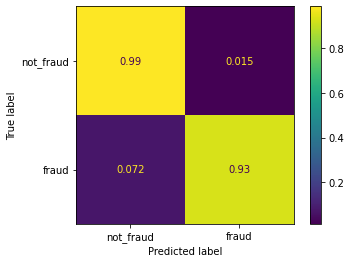

In [35]:
#result on training data
preds = modelLR.predict(X_train_under)
cm = confusion_matrix(y_train_under, preds, labels=modelLR.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

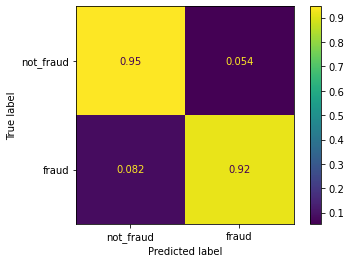

In [36]:
#result on test data (undersample)
preds = modelLR.predict(X_test_under)
cm = confusion_matrix(y_test_under, preds, labels=modelLR.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

In [18]:
print ("")
print ("Classification Report: ")
print (classification_report(y_test_under, preds))

print ("")
print ("Accuracy Score: ", accuracy_score(y_test_under, preds))


Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       149
           1       0.94      0.92      0.93       147

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Accuracy Score:  0.9324324324324325


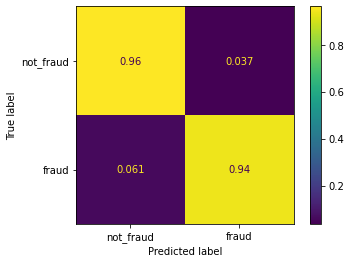

In [37]:
# we apply it to the test data seet not under sampled
preds = modelLR.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=modelLR.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

In [20]:
print ("")
print ("Classification Report: ")
print (classification_report(y_test, preds))

print ("")
print ("Accuracy Score: ", accuracy_score(y_test, preds))


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     85296
           1       0.04      0.94      0.08       147

    accuracy                           0.96     85443
   macro avg       0.52      0.95      0.53     85443
weighted avg       1.00      0.96      0.98     85443


Accuracy Score:  0.9632737614550051


## Train with full data set

In [185]:
# train on balanced dataset
train_start_time = time.time()
eval_set=[(X_test,y_test)]
modelLR.fit(X_train, np.ravel(y_train))
train_end_time = time.time()

print("Training takes:", int(train_end_time-train_start_time), "seconds")

Training takes: 1 seconds


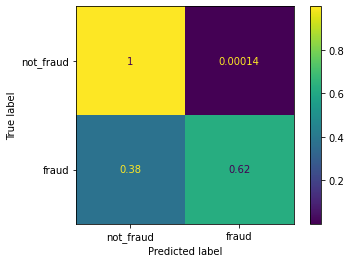

In [186]:
#result on training data
preds = modelLR.predict(X_train)
cm = confusion_matrix(y_train, preds, labels=modelLR.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

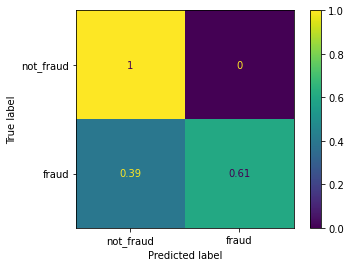

In [190]:
#result on test data (undersample)
preds = modelLR.predict(X_test_under)
cm = confusion_matrix(y_test_under, preds, labels=modelLR.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

In [191]:
print ("")
print ("Classification Report: ")
print (classification_report(y_test_under, preds))

print ("")
print ("Accuracy Score: ", accuracy_score(y_test_under, preds))


Classification Report: 
              precision    recall  f1-score   support

           0       0.72      1.00      0.84       149
           1       1.00      0.61      0.75       147

    accuracy                           0.80       296
   macro avg       0.86      0.80      0.80       296
weighted avg       0.86      0.80      0.80       296


Accuracy Score:  0.8040540540540541


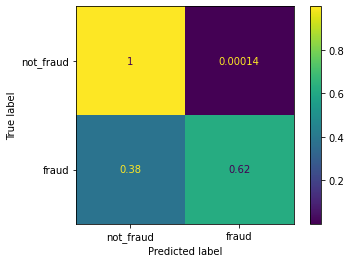

In [192]:
# we apply it to the test data seet not under sampled
preds = modelLR.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=modelLR.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

In [193]:
print ("")
print ("Classification Report: ")
print (classification_report(y_test, preds))

print ("")
print ("Accuracy Score: ", accuracy_score(y_test, preds))


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.88      0.62      0.73       147

    accuracy                           1.00     85443
   macro avg       0.94      0.81      0.86     85443
weighted avg       1.00      1.00      1.00     85443


Accuracy Score:  0.999204147794436


## XgBoost

In [21]:
model = xgb.XGBClassifier(
    n_estimators=2000,
    max_depth = 10,
    early_stopping_rounds=10,
    learning_rate=0.1,
    tree_method="exact",
    booster='gbtree',
    importance_type='gain',
    # scale up the weight of positive samples
    use_label_encoder=False,
    eval_metric=["error","logloss"]
)

## Result with Training on under sampled data set

In [22]:
# train on balanced dataset
train_start_time = time.time()
eval_set=[(X_test_under,y_test_under)]
model.fit(X_train_under, np.ravel(y_train_under),eval_set=eval_set,verbose=False)
train_end_time = time.time()

print("Training takes:", int(train_end_time-train_start_time), "seconds")

Training takes: 1 seconds


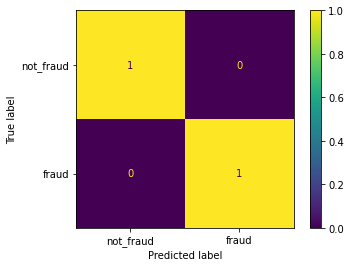

In [23]:
#result on training data
preds = model.predict(X_train_under)
cm = confusion_matrix(y_train_under, preds, labels=model.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

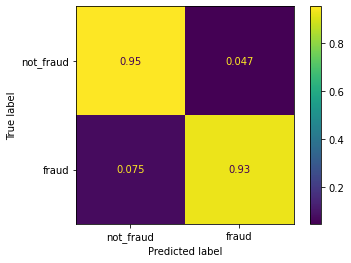

In [24]:
#result on test data (undersample)
preds = model.predict(X_test_under)
cm = confusion_matrix(y_test_under, preds, labels=model.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

In [25]:
print ("")
print ("Classification Report: ")
print (classification_report(y_test_under, preds))

print ("")
print ("Accuracy Score: ", accuracy_score(y_test_under, preds))


Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       149
           1       0.95      0.93      0.94       147

    accuracy                           0.94       296
   macro avg       0.94      0.94      0.94       296
weighted avg       0.94      0.94      0.94       296


Accuracy Score:  0.9391891891891891


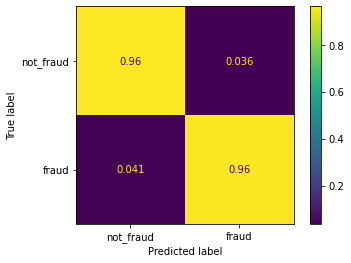

In [26]:
# we apply it to the test data seet not under sampled
preds = model.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=model.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

In [27]:
print ("")
print ("Classification Report: ")
print (classification_report(y_test, preds))

print ("")
print ("Accuracy Score: ", accuracy_score(y_test, preds))


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     85296
           1       0.04      0.96      0.08       147

    accuracy                           0.96     85443
   macro avg       0.52      0.96      0.53     85443
weighted avg       1.00      0.96      0.98     85443


Accuracy Score:  0.963601465304355


## Result with training on unbalaced dataset

In [28]:
# train on balanced dataset
train_start_time = time.time()
eval_set=[(X_test,y_test)]
model.fit(X_train, np.ravel(y_train),eval_set=eval_set,verbose=False)
train_end_time = time.time()

print("Training takes:", int(train_end_time-train_start_time), "seconds")

Training takes: 29 seconds


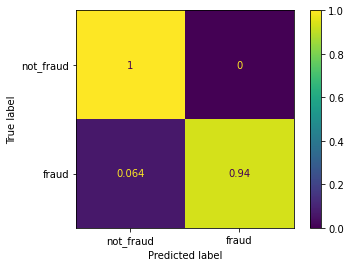

In [29]:
#result on training data
preds = model.predict(X_train)
cm = confusion_matrix(y_train, preds, labels=model.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

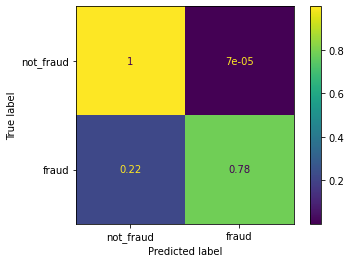

In [30]:
#result on test data
preds = model.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=model.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

In [31]:
print ("")
print ("Classification Report: ")
print (classification_report(y_test, preds))

print ("")
print ("Accuracy Score: ", accuracy_score(y_test, preds))


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.95      0.78      0.86       147

    accuracy                           1.00     85443
   macro avg       0.98      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443


Accuracy Score:  0.9995552590615966


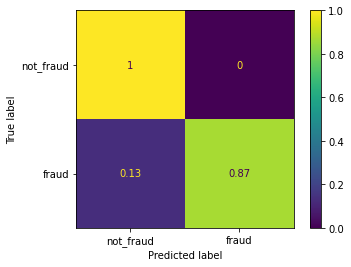

In [32]:
#result on test data undersample
preds = model.predict(X_test_under)
cm = confusion_matrix(y_test_under, preds, labels=model.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

In [33]:
print ("")
print ("Classification Report: ")
print (classification_report(y_test_under, preds))

print ("")
print ("Accuracy Score: ", accuracy_score(y_test_under, preds))


Classification Report: 
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       149
           1       1.00      0.87      0.93       147

    accuracy                           0.94       296
   macro avg       0.94      0.94      0.94       296
weighted avg       0.94      0.94      0.94       296


Accuracy Score:  0.9358108108108109


### Conclusion
Training on unbalanced data gives a high accuracy result 0.99 for the test data set but a poor classification of the minority class (0.78). But on the under sample data set the XGBoost works very well with an 0.94 accuracy on the test data and 0.93 for the fraud data. Furthermore we observ that training on a small data set does impact his capability of generalization, because on the unbalced test data the accuracy is 0.96 and fruad data accurancy of 0.96 which is even better.

# Auto Encoder

## Under complete Auto Encoder

In [194]:
nb_epoch = 50
batch_size = 128
input_dim = X_train.shape[1] #num of columns, 30
encoding_dim = 18
hidden_dim1 = 10 
hidden_dim2 = 6
learning_rate = 1e-7

In [195]:
# This returns a tensor
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim1, activation="elu")(encoder)
encoder = Dense(hidden_dim2, activation="tanh")(encoder)
decoder = Dense(hidden_dim2, activation='elu')(encoder)
decoder = Dense(hidden_dim1, activation='tanh')(decoder)
decoder = Dense(input_dim, activation='elu')(decoder)


# This creates a model that includes
# the Input layer and four Dense layers
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [196]:
# Configure the learning process, by compiling the model
autoencoder.compile(optimizer='adam',
                    metrics=['accuracy'],
                    loss='mean_squared_error')

# Saving the model
cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                     save_best_only=True,
                     verbose=0)

# TensorBoard basic visualizations.
# This callback writes a log for TensorBoard, 
# which allows you to visualize dynamic graphs of your training and test metrics
tb = TensorBoard(log_dir='./logs',
                 histogram_freq=0,
                 write_graph=True,
                 write_images=True)



# Train on full data set unbalanced 

In [156]:
# we train on unbalanced data set
train_start_time = time.time()
modelAEUB = autoencoder.fit(x=X_train, y=X_train,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          verbose=1,
                          callbacks=[cp, tb]).history
train_end_time = time.time()

print("Training takes:", int(train_end_time-train_start_time), "seconds")

Epoch 1/50
1558/1558 [==============================] - 3s 2ms/step - loss: 0.7832 - accuracy: 0.5035 - val_loss: 0.6951 - val_accuracy: 0.5873
Epoch 2/50
1558/1558 [==============================] - 3s 2ms/step - loss: 0.6796 - accuracy: 0.5937 - val_loss: 0.6680 - val_accuracy: 0.5961
Epoch 3/50
1558/1558 [==============================] - 3s 2ms/step - loss: 0.6604 - accuracy: 0.5988 - val_loss: 0.6532 - val_accuracy: 0.5999
Epoch 4/50
1558/1558 [==============================] - 3s 2ms/step - loss: 0.6478 - accuracy: 0.6006 - val_loss: 0.6430 - val_accuracy: 0.6052
Epoch 5/50
1558/1558 [==============================] - 3s 2ms/step - loss: 0.6391 - accuracy: 0.6042 - val_loss: 0.6353 - val_accuracy: 0.6027
Epoch 6/50
1558/1558 [==============================] - 3s 2ms/step - loss: 0.6301 - accuracy: 0.6066 - val_loss: 0.6245 - val_accuracy: 0.6077
Epoch 7/50
1558/1558 [==============================] - 3s 2ms/step - loss: 0.6177 - accuracy: 0.6070 - val_loss: 0.6130 - val_accuracy:

In [73]:
# Visualizing metrics on local system
!tensorboard --logdir="logs" --host localhost --port 8080

^C


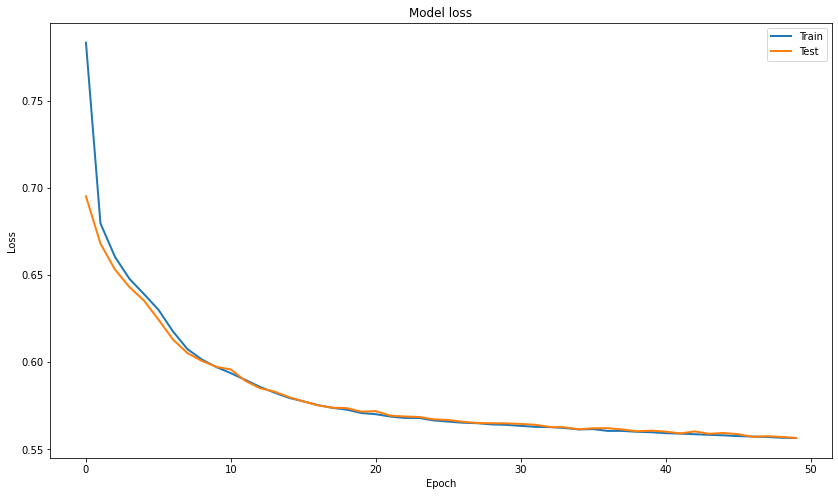

In [197]:
plt.figure(figsize=(14, 8))
plt.plot(modelAEUB['loss'], linewidth=2, label='Train')
plt.plot(modelAEUB['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [198]:
# evaluation on train data
train_x_predictions = autoencoder.predict(X_train)
mse = np.mean(np.power(X_train - train_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_train["Class"]})
error_df.describe()

6231/6231 [==============================] - 9s 1ms/step


,Reconstruction_error,True_class
count,199364.000000,199364.000000
mean,1.180635,0.001731
std,4.110043,0.041563
min,0.125512,0.000000
25%,0.491052,0.000000
50%,0.714041,0.000000
75%,1.066147,0.000000
max,531.505444,1.000000


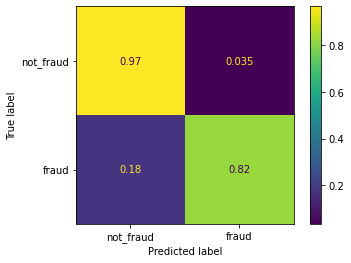

In [199]:
#result on train data
pred_y = [1 if e > THRESHOLD_FIXED else 0 for e in error_df.Reconstruction_error.values]
cm = confusion_matrix(y_train, pred_y, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

In [200]:
#evaluation on test data
test_x_predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test["Class"]})
error_df.describe()

2671/2671 [==============================] - 4s 1ms/step


,Reconstruction_error,True_class
count,85443.000000,85443.000000
mean,1.178214,0.001720
std,7.433737,0.041443
min,0.160197,0.000000
25%,0.489184,0.000000
50%,0.711946,0.000000
75%,1.058008,0.000000
max,1827.554597,1.000000


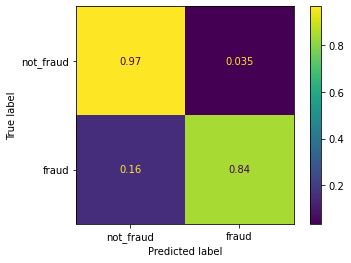

In [201]:
#result on test data
pred_y = [1 if e > THRESHOLD_FIXED else 0 for e in error_df.Reconstruction_error.values]
cm = confusion_matrix(y_test, pred_y, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

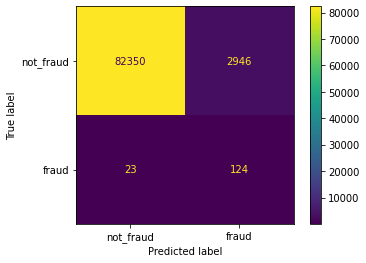

In [202]:
#result on test data
pred_y = [1 if e > THRESHOLD_FIXED else 0 for e in error_df.Reconstruction_error.values]
cm = confusion_matrix(y_test, pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

In [206]:
print("accuracy = "+str((82350+124)/(len(y_test))))

accuracy = 0.9652516882600096


In [162]:
#evaluation on test data
test_x_predictions = autoencoder.predict(X_test_under)
mse = np.mean(np.power(X_test_under - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test_under["Class"]})
error_df.describe()

10/10 [==============================] - 0s 999us/step


,Reconstruction_error,True_class
count,296.000000,296.000000
mean,12.003166,0.496622
std,29.975106,0.500835
min,0.049902,0.000000
25%,0.246129,0.000000
50%,0.601980,0.000000
75%,7.205777,1.000000
max,249.847250,1.000000


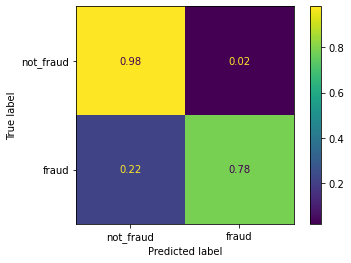

In [163]:
#result on test data
pred_y = [1 if e > THRESHOLD_FIXED else 0 for e in error_df.Reconstruction_error.values]
cm = confusion_matrix(y_test_under, pred_y, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

# Train on balanced data set

In [207]:
# we train on unbalanced data set
train_start_time = time.time()
modelAEB = autoencoder.fit(x=X_train_under, y=X_train_under,
                          epochs=nb_epoch*3,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X_test_under, X_test_under),
                          verbose=1,
                          callbacks=[cp, tb]).history
train_end_time = time.time()

print("Training takes:", int(train_end_time-train_start_time), "seconds")

Epoch 1/150
6/6 [==============================] - 1s 57ms/step - loss: 13.5539 - accuracy: 0.0378 - val_loss: 14.7283 - val_accuracy: 0.0811
Epoch 2/150
6/6 [==============================] - 0s 25ms/step - loss: 13.4235 - accuracy: 0.1032 - val_loss: 14.6152 - val_accuracy: 0.1081
Epoch 3/150
6/6 [==============================] - 0s 19ms/step - loss: 13.3111 - accuracy: 0.1337 - val_loss: 14.5090 - val_accuracy: 0.1318
Epoch 4/150
6/6 [==============================] - 0s 23ms/step - loss: 13.1990 - accuracy: 0.1599 - val_loss: 14.4043 - val_accuracy: 0.1655
Epoch 5/150
6/6 [==============================] - 0s 21ms/step - loss: 13.0901 - accuracy: 0.1730 - val_loss: 14.2979 - val_accuracy: 0.1926
Epoch 6/150
6/6 [==============================] - 0s 30ms/step - loss: 12.9721 - accuracy: 0.1875 - val_loss: 14.1911 - val_accuracy: 0.1892
Epoch 7/150
6/6 [==============================] - 0s 18ms/step - loss: 12.8586 - accuracy: 0.1904 - val_loss: 14.0802 - val_accuracy: 0.1959
Epoch 

6/6 [==============================] - 0s 24ms/step - loss: 10.9126 - accuracy: 0.2427 - val_loss: 12.2459 - val_accuracy: 0.3007
Epoch 59/150
6/6 [==============================] - 0s 24ms/step - loss: 10.9033 - accuracy: 0.2442 - val_loss: 12.2382 - val_accuracy: 0.2939
Epoch 60/150
6/6 [==============================] - 0s 19ms/step - loss: 10.8951 - accuracy: 0.2456 - val_loss: 12.2290 - val_accuracy: 0.2973
Epoch 61/150
6/6 [==============================] - 0s 21ms/step - loss: 10.8864 - accuracy: 0.2442 - val_loss: 12.2208 - val_accuracy: 0.2973
Epoch 62/150
6/6 [==============================] - 0s 24ms/step - loss: 10.8781 - accuracy: 0.2485 - val_loss: 12.2124 - val_accuracy: 0.2973
Epoch 63/150
6/6 [==============================] - 0s 18ms/step - loss: 10.8693 - accuracy: 0.2500 - val_loss: 12.2039 - val_accuracy: 0.2973
Epoch 64/150
6/6 [==============================] - 0s 20ms/step - loss: 10.8608 - accuracy: 0.2471 - val_loss: 12.1963 - val_accuracy: 0.2973
Epoch 65/150

KeyboardInterrupt: 

In [ ]:
# Visualizing metrics on local system
!tensorboard --logdir="logs" --host localhost --port 8080

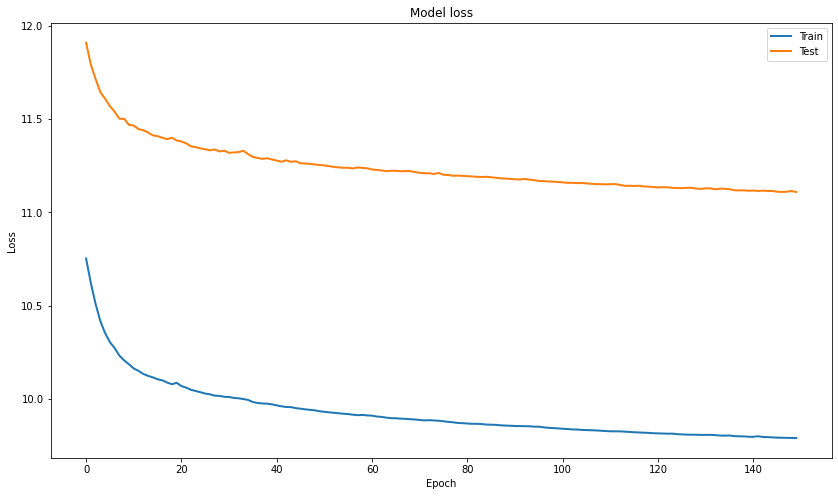

In [208]:
plt.figure(figsize=(14, 8))
plt.plot(modelAEB['loss'], linewidth=2, label='Train')
plt.plot(modelAEB['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [209]:
# evaluation on train data
train_x_predictions = autoencoder.predict(X_train_under)
mse = np.mean(np.power(X_train_under - train_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_train_under["Class"]})
error_df.describe()

22/22 [==============================] - 0s 1ms/step


,Reconstruction_error,True_class
count,688.000000,688.000000
mean,10.589745,0.501453
std,22.226512,0.500362
min,0.166252,0.000000
25%,0.566445,0.000000
50%,1.244922,1.000000
75%,7.292461,1.000000
max,178.061344,1.000000


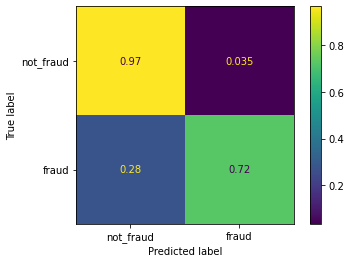

In [211]:
#result on train data
pred_y = [1 if e > THRESHOLD_FIXED else 0 for e in error_df.Reconstruction_error.values]
cm = confusion_matrix(y_train_under, pred_y, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

In [212]:
#evaluation on test data under sampled
train_x_predictions = autoencoder.predict(X_test_under)
mse = np.mean(np.power(X_test_under - train_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test_under["Class"]})
error_df.describe()

10/10 [==============================] - 0s 1ms/step


,Reconstruction_error,True_class
count,296.000000,296.000000
mean,11.964656,0.496622
std,30.088462,0.500835
min,0.203679,0.000000
25%,0.636662,0.000000
50%,1.259394,0.000000
75%,7.003213,1.000000
max,255.415002,1.000000


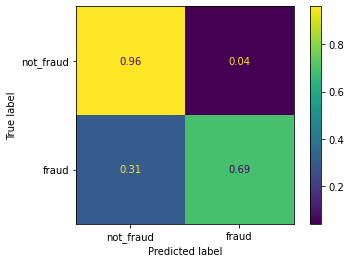

In [213]:
#result on test data under sample
pred_y = [1 if e > THRESHOLD_FIXED else 0 for e in error_df.Reconstruction_error.values]
cm = confusion_matrix(y_test_under, pred_y, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

In [214]:
#evaluation on test data under sampled
train_x_predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - train_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test["Class"]})
error_df.describe()

2671/2671 [==============================] - 4s 2ms/step


,Reconstruction_error,True_class
count,85443.000000,85443.000000
mean,1.033487,0.001720
std,7.202146,0.041443
min,0.131293,0.000000
25%,0.400934,0.000000
50%,0.616090,0.000000
75%,0.932163,0.000000
max,1795.602906,1.000000


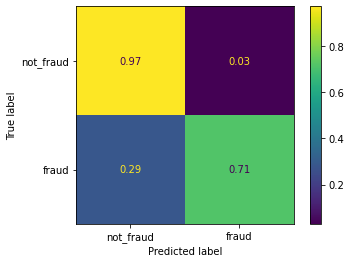

In [215]:
#result on test data
pred_y = [1 if e > THRESHOLD_FIXED else 0 for e in error_df.Reconstruction_error.values]
cm = confusion_matrix(y_test, pred_y, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

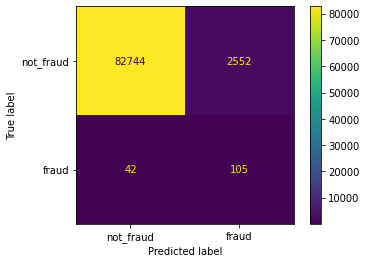

In [216]:
#result on test data
pred_y = [1 if e > THRESHOLD_FIXED else 0 for e in error_df.Reconstruction_error.values]
cm = confusion_matrix(y_test, pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

In [218]:
print("accuracy = "+str((82744+105)/len(y_test)))

accuracy = 0.9696405790995166
